In [2]:
import re
from queue import Queue
from typing import Iterable
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from scipy.stats import entropy
from scipy import spatial

from Bio.Data import CodonTable
from mutspec.utils import possible_sbs12

import warnings
warnings.filterwarnings("ignore")

In [3]:
path_to_tree = "../data/example_nematoda/anc.treefile.rooted"
path_to_states = "../data/example_nematoda/genes_states.tsv"
path_to_leaves = "../data/example_nematoda/leaves_states_nematoda.tsv"

In [4]:
tree = tree = PhyloTree(path_to_tree, format=1)

In [5]:
tree.describe()

Number of leaf nodes:	144
Total number of nodes:	287
Rooted:	Yes
Most distant node:	Meloidogyne_javanica
Max. distance:	4.701266


In [8]:
# print(tree.get_ascii())
# tree.show()

In [ ]:
anc = pd.read_csv(path_to_states, sep="\t", comment='#',)
leaves = pd.read_csv(path_to_leaves, sep="\t")

states = pd.concat([anc, leaves]).sort_values(["Node", "Part", "Site"])
print(states.shape)
states.head()

In [6]:
anc[anc.Node == "Node6"]

,Node,Part,Site,State,p_A,p_C,p_G,p_T
1239210,Node6,1,1,A,0.60248,0.03162,0.16067,0.20522
1239211,Node6,1,2,T,0.09477,0.06599,0.07400,0.76524
1239212,Node6,1,3,A,0.60248,0.03162,0.16067,0.20522
1239213,Node6,1,4,T,0.09391,0.00835,0.00776,0.88998
1239214,Node6,1,5,T,0.00043,0.00255,0.00034,0.99668
...,...,...,...,...,...,...,...,...
1251850,Node6,12,683,G,0.22399,0.03617,0.50514,0.23470
1251851,Node6,12,684,T,0.10839,0.07148,0.08464,0.73549
1251852,Node6,12,685,T,0.10839,0.07148,0.08464,0.73549
1251853,Node6,12,686,T,0.10839,0.07148,0.08464,0.73549


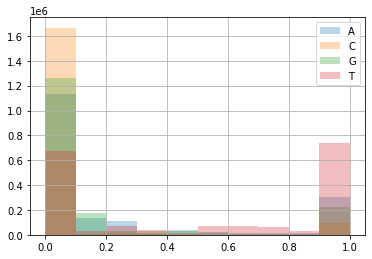

In [7]:
anc.p_A.hist(alpha=.3, label="A")
anc.p_C.hist(alpha=.3, label="C")
anc.p_G.hist(alpha=.3, label="G")
anc.p_T.hist(alpha=.3, label="T")
plt.legend()

## 21% of positions are uncertain

In [8]:
np.any(anc[["p_A", "p_C", "p_G", "p_T"]] > 0.8, 1).value_counts(normalize=True)

True     0.788926
False    0.211074
dtype: float64

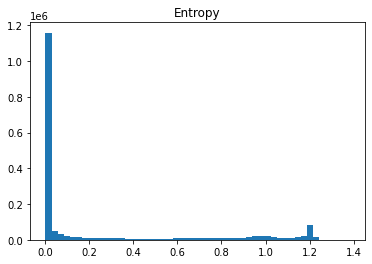

In [10]:
mentr = entropy(anc[["p_A", "p_C", "p_G", "p_T"]], axis=1)
plt.hist(mentr, bins=50)
plt.title("Entropy");

<AxesSubplot:>

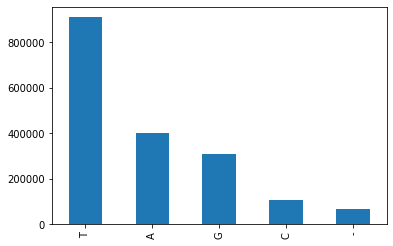

In [11]:
anc.State.value_counts().plot.bar()

## MUTSPEC

In [7]:
_path = "../data/processed/nematoda/30-05-22-16-39-29_rooted"

mutations = pd.read_csv(f"{_path}/mutations.tsv", sep="\t")
edge_mutspec12 = pd.read_csv(f"{_path}/mutspec12.tsv", sep="\t")
edge_mutspec12genes = pd.read_csv(f"{_path}/mutspec12genes.tsv", sep="\t")
freqs = pd.read_csv(f"{_path}/freqs.tsv", sep="\t")

edge_mutspec_all = edge_mutspec12[edge_mutspec12.Label == "all"]
edge_mutspec_syn = edge_mutspec12[edge_mutspec12.Label == "syn"]
edge_mutspec_ff  = edge_mutspec12[edge_mutspec12.Label == "ff"]

In [8]:
mutations

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene
0,T[T>G]T,0,6,3,ATT,ATG,I,M,Node4,Node5,1
1,T[T>A]T,0,53,2,TTT,TAT,F,Y,Node4,Node5,1
2,T[T>A]T,0,76,1,TTT,ATT,F,I,Node4,Node5,1
3,A[A>G]G,0,163,1,AGT,GGT,S,G,Node4,Node5,1
4,A[G>A]T,0,208,1,GTT,ATT,V,I,Node4,Node5,1
...,...,...,...,...,...,...,...,...,...,...,...
99671,T[A>G]A,1,231,3,TTA,TTG,L,L,Node94,Cylicocyclus_ashworthi,12
99672,G[G>A]G,2,234,3,AGG,AGA,S,S,Node94,Cylicocyclus_ashworthi,12
99673,G[G>T]A,2,237,3,GGG,GGT,G,G,Node94,Cylicocyclus_ashworthi,12
99674,T[A>G]A,2,246,3,GTA,GTG,V,V,Node94,Cylicocyclus_ashworthi,12


In [9]:
# mutations.loc[(mutations.Label < 0) & (mutations.RefAa == "*"), "Label"] = -2

In [10]:
nonsense_muts = mutations[
    (mutations.Label < 0) & 
    (mutations.Mut.str.fullmatch("[ACGT]\[[ACGT]>[ACGT]\][ACGT]"))
]
nonsense_muts

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene
319,T[A>G]A,-2,1691,2,TAA,TGA,*,W,Node4,Node11,2
435,T[A>T]A,-1,7,1,AAA,TAA,K,*,Node4,Node11,5
1318,G[G>T]A,-1,361,1,GAG,TAG,E,*,Node3,Node2,6
1594,T[A>T]A,-1,148,1,AAA,TAA,K,*,Node5,Node6,1
2263,A[C>T]A,-1,1090,1,CAA,TAA,Q,*,Node5,Node7,2
...,...,...,...,...,...,...,...,...,...,...,...
63224,A[T>A]T,-1,72,3,TAT,TAA,Y,*,Node82,Node97,9
65229,A[T>A]A,-1,825,3,TAT,TAA,Y,*,Node115,Node116,7
65252,A[A>C]C,-2,63,3,TAA,TAC,*,Y,Node115,Node116,9
71995,T[A>T]A,-2,71,2,TAA,TTA,*,L,Node97,Node98,9


In [11]:
genes_order = "ATP6 ATP8 COX1 COX2 COX3 CYTB ND1 ND2 ND3 ND4 ND4L ND5".split()

_mutations_description = mutations[
    (mutations.Mut.str.fullmatch("[ACGT]\[[ACGT]>[ACGT]\][ACGT]"))
].groupby(["Label", "Gene"]).Mut.count().reset_index()
_mutations_description["Label"] = _mutations_description.Label.map(
    {-3: "Stop to stop", -2: "Stop loss", -1: "Stop gain", 0: "all", 1: "syn", 2: "syn4f"})

_pivot_mutations = pd.pivot_table(
    _mutations_description,
    values="Mut", index="Gene", columns="Label", fill_value=0
)[["Stop loss",  "Stop gain", "all", "syn", "syn4f"]]

_pivot_mutations.index = _pivot_mutations.index.map(
    {i: x for i, x in enumerate(genes_order, 1)})
_pivot_mutations

Label,Stop loss,Stop gain,all,syn,syn4f
Gene,,,,,
ATP6,3,2,1961,1562,1663
ATP8,4,1,2213,4989,6466
COX1,0,0,1534,2334,2258
COX2,4,0,1993,2577,2910
COX3,4,2,3410,3661,3988
CYTB,4,2,2790,2955,3057
ND1,5,5,4178,2723,1907
ND2,1,0,1339,1085,865
ND3,8,3,4569,4062,4247


### Translate MutSpec to heavy strand

(Genes are on Heavy strand, but sequenced Light strand equivalent - mRNA)

In [12]:
translator = str.maketrans("ACGT", "TGCA")


def rev_comp(mut: str):
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [13]:
edge_mutspec12["Mut"] = edge_mutspec12["Mut"].str.translate(translator)
edge_mutspec12genes["Mut"] = edge_mutspec12genes["Mut"].str.translate(translator)

edge_mutspec_all["Mut"] = edge_mutspec_all["Mut"].str.translate(translator)
edge_mutspec_syn["Mut"] = edge_mutspec_syn["Mut"].str.translate(translator)
edge_mutspec_ff["Mut"] = edge_mutspec_ff["Mut"].str.translate(translator)

### Plot mutations and MutSpec

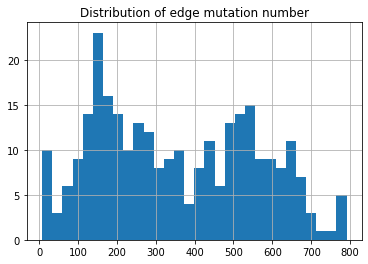

In [14]:
mutations.groupby("AltNode").apply(len).hist(bins=30)
plt.title("Distribution of edge mutation number");

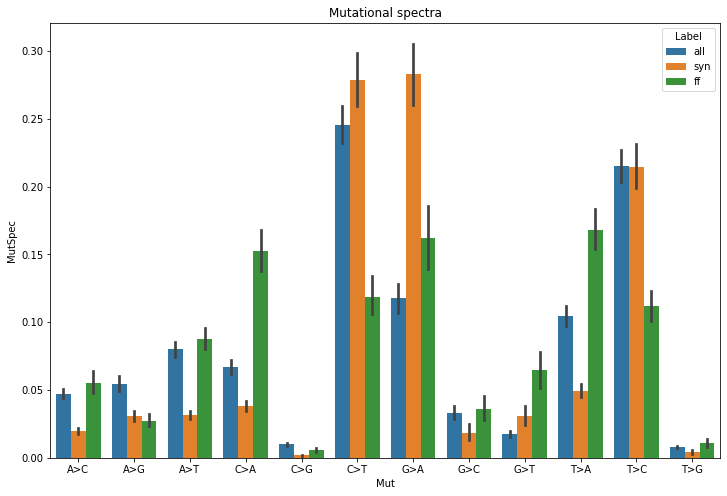

In [17]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Mut", y="MutSpec", hue="Label", data=edge_mutspec12, order=sorted(edge_mutspec12.Mut.unique()))
plt.title("Mutational spectra")
plt.show()

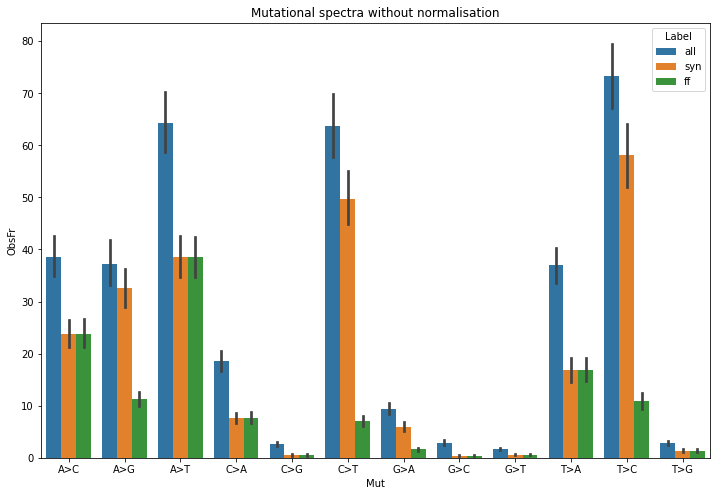

In [18]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Mut", y="ObsFr", hue="Label", data=edge_mutspec12, order=sorted(edge_mutspec12.Mut.unique()))
plt.title("Mutational spectra without normalisation")
plt.show()

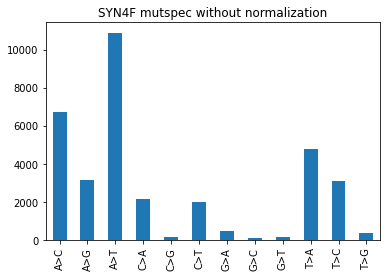

In [19]:
mutations["MutBase"] = mutations.Mut.str.slice(2, 5).str.translate(translator)
mutations[mutations.Label == 2].MutBase.value_counts().sort_index().plot.bar()
plt.title("SYN4F mutspec without normalization")
plt.show()

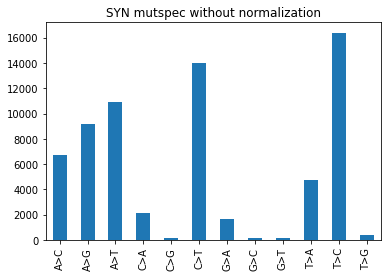

In [20]:
mutations[mutations.Label >= 1].MutBase.value_counts().sort_index().plot.bar()
plt.title("SYN mutspec without normalization")
plt.show()

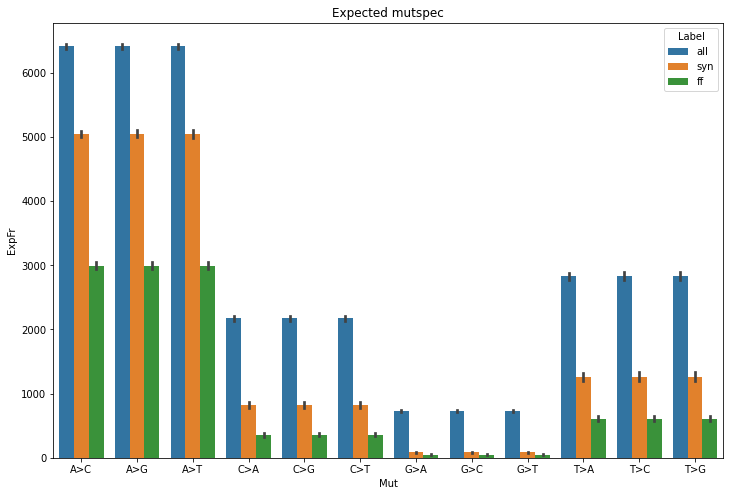

In [21]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Mut", y="ExpFr", hue="Label", data=edge_mutspec12, order=sorted(edge_mutspec12.Mut.unique()))
plt.title("Expected mutspec")
plt.show()

In [22]:
freqs

,Node,Gene,Label,A,C,G,T,AAA,AAC,AAG,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,Node3,1,all,223,55,195,522,12,5,15,...,2,10,30,5,20,31,65,8,39,170
1,Node3,1,syn,73,9,71,414,4,1,4,...,0,1,6,1,11,11,48,1,22,96
2,Node3,1,ff,24,3,39,255,0,0,0,...,0,0,0,0,9,6,21,0,3,42
3,Node3,2,all,402,156,309,840,24,15,22,...,9,20,29,20,49,44,115,19,60,207
4,Node3,2,syn,137,2,58,906,7,5,3,...,0,1,5,3,8,13,53,12,37,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10219,Node94,11,syn,316,26,124,584,11,1,9,...,0,1,11,3,14,22,63,6,30,136
10220,Node94,11,ff,183,18,72,297,0,0,0,...,0,0,6,0,6,3,21,3,12,24
10221,Node94,12,all,164,18,114,370,15,0,5,...,3,2,11,3,10,34,45,5,34,119
10222,Node94,12,syn,72,8,72,215,2,0,1,...,0,0,7,2,5,21,24,0,12,67


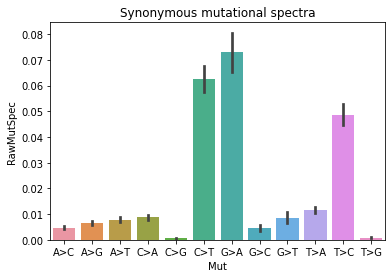

In [23]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_syn, order=sorted(edge_mutspec_syn.Mut.unique()));
plt.title("Synonymous mutational spectra")
plt.show()

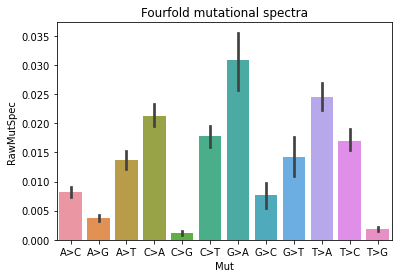

In [24]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_ff, order=sorted(edge_mutspec_ff.Mut.unique()));
plt.title("Fourfold mutational spectra")
plt.show()

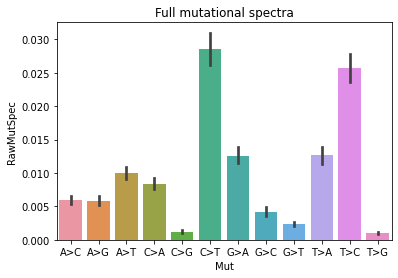

In [25]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_all, order=sorted(edge_mutspec_all.Mut.unique()));
plt.title("Full mutational spectra")
plt.show()

### Prepare edge data for tree vizualisation

In [26]:
edge_mutspec12

,Mut,ObsFr,ExpFr,RawMutSpec,MutSpec,RefNode,AltNode,Label
0,T>A,32,2551.0,0.012544,0.179481,Node3,Node4,all
1,A>T,26,6911.0,0.003762,0.053828,Node3,Node4,all
2,C>T,23,1982.0,0.011604,0.166037,Node3,Node4,all
3,C>A,18,1982.0,0.009082,0.129942,Node3,Node4,all
4,T>C,17,2551.0,0.006664,0.095349,Node3,Node4,all
...,...,...,...,...,...,...,...,...
10147,C>A,6,684.0,0.008772,0.041124,Node94,Cylicocyclus_ashworthi,ff
10148,T>G,2,1098.0,0.001821,0.008539,Node94,Cylicocyclus_ashworthi,ff
10149,C>G,1,684.0,0.001462,0.006854,Node94,Cylicocyclus_ashworthi,ff
10150,G>C,1,129.0,0.007752,0.036342,Node94,Cylicocyclus_ashworthi,ff


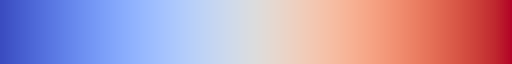

In [28]:
plt.cm.coolwarm

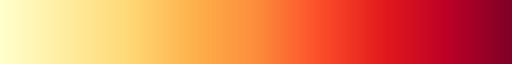

In [29]:
plt.cm.YlOrRd

In [16]:
[matplotlib.colors.to_hex(x) for x in plt.cm.coolwarm([.1, .3, .4, 1.])]

['#5977e3', '#9ebeff', '#c0d4f5', '#b40426']

In [17]:
def prepare_css_map(mutspec: pd.DataFrame, filename: str, sbs="C>T", cm=plt.cm.coolwarm, width=3, appendix=0.1):
    """
    stroke:green Individual Colobus Cercopithecus
    <br>
    stroke:#color Individual name1 name2 ...

    https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html

    http://gensoft.pasteur.fr/docs/newick-utils/1.6/nwutils_tutorial.pdf
    """
    assert bool(re.match("[ACGT]>[ACGT]", sbs)), f"sbs ({sbs}) is not appropriate"
    cols = ["RefNode", "AltNode", "MutSpec"]
    for c in cols:
        assert c in mutspec, f"Column {c} is not in mutspec dataframe"
    
    ms = mutspec[mutspec.Mut == sbs]

    handle = open(filename, "w")
    print(f"min: {ms.MutSpec.min():.2f}, max: {ms.MutSpec.max():.2f}")
    plt.hist(ms["MutSpec"], bins=20)
    plt.xlim(0, 0.9)
    plt.title(sbs)
    plt.show()
    colors = cm(ms["MutSpec"].values + appendix)
    for c, node in zip(colors, ms["AltNode"].values):
        chex = matplotlib.colors.to_hex(c)
        line = f"\"stroke:{chex}; stroke-width:{width}\" Individual {node}\n"
        handle.write(line)
    handle.close()

In [18]:
edge_mutspec_syn[edge_mutspec_syn.Mut == "C>T"]

,Mut,ObsFr,ExpFr,RawMutSpec,MutSpec,RefNode,AltNode,Label
12,C>T,10,544.0,0.018382,0.218652,Node4,Node5,syn
49,C>T,21,544.0,0.038603,0.153828,Node4,Node11,syn
84,C>T,34,555.0,0.061261,0.663177,Node3,Node27,syn
123,C>T,10,555.0,0.018018,0.112814,Node3,Node2,syn
158,C>T,16,554.0,0.028881,0.131341,Node5,Node6,syn
...,...,...,...,...,...,...,...,...
9985,C>T,97,943.0,0.102863,0.191323,Node92,Cylicocyclus_insigne,syn
10021,C>T,32,1028.0,0.031128,0.299027,Node93,Node94,syn
10057,C>T,79,1028.0,0.076848,0.222165,Node93,Cylicocyclus_nassatus,syn
10093,C>T,83,1060.0,0.078302,0.215872,Node94,Cylicocyclus_radiatus,syn


A>C
min: 0.00, max: 0.15


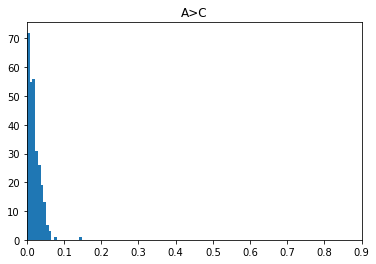

A>G
min: 0.00, max: 0.21


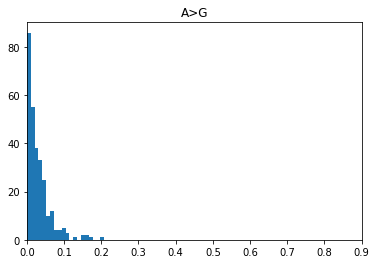

A>T
min: 0.00, max: 0.12


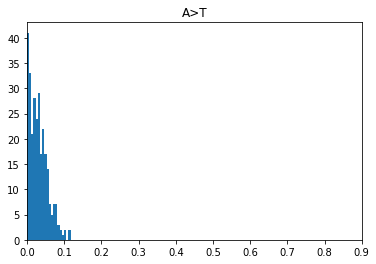

C>A
min: 0.00, max: 0.18


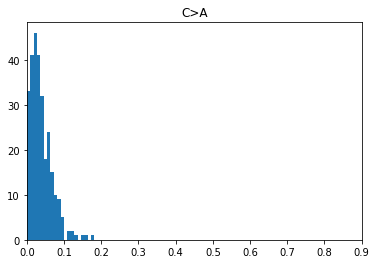

C>G
min: 0.00, max: 0.02


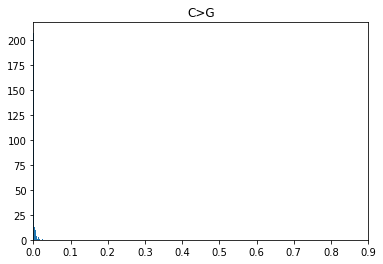

C>T
min: 0.00, max: 0.87


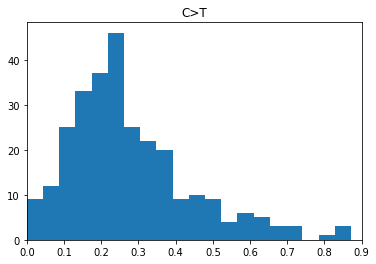

G>A
min: 0.00, max: 0.70


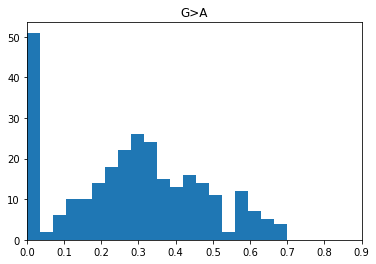

G>C
min: 0.00, max: 0.65


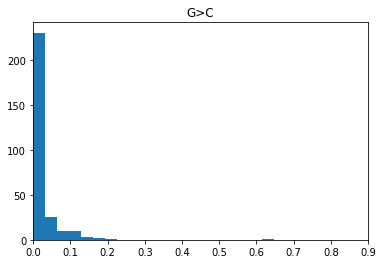

G>T
min: 0.00, max: 0.42


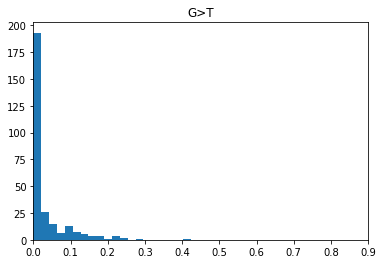

T>A
min: 0.00, max: 0.22


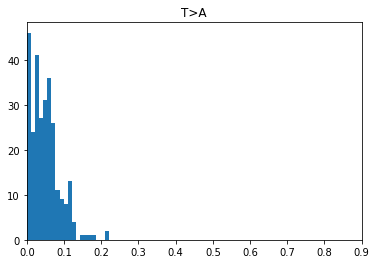

T>C
min: 0.00, max: 0.87


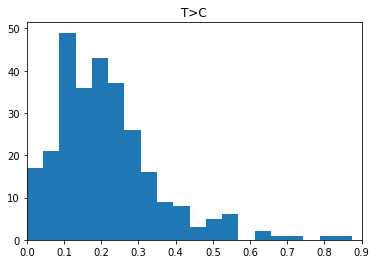

T>G
min: 0.00, max: 0.19


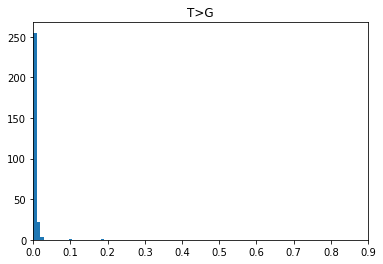

In [19]:
for sbs in possible_sbs12:
    print(sbs)
    prepare_css_map(edge_mutspec_syn, f"../data/share/nematoda/trees/style/{sbs}.css.map", sbs, plt.cm.YlOrRd)

In [20]:
def prepare_one_mut_share_file(mutspec: pd.DataFrame, filename: str, sbs="C>T"):
    assert bool(re.match("[ACGT]>[ACGT]", sbs)), "sbs is not appropriate"
    cols = ["RefNode", "AltNode", "MutSpec"]
    for c in cols:
        assert c in mutspec, f"Column {c} is not in mutspec dataframe"
    
    shares = mutspec[mutspec.Mut == sbs][cols]
    shares.to_csv(filename, "\t", index=None)
    return shares


In [23]:
for sbs in possible_sbs12:
    prepare_one_mut_share_file(
        edge_mutspec12[edge_mutspec12.Label == "syn"], 
        f"../data/share/{sbs}_edge_mutspec.tsv"
    )

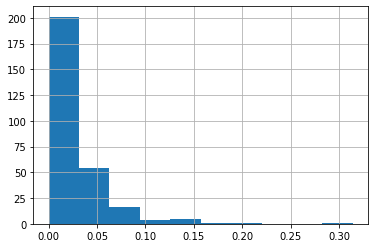

In [25]:
edge_mutspec_ff[edge_mutspec_ff.Mut == "A>G"]["MutSpec"].hist();

### Grouping nodes on tree for everage mutspec

In [145]:
path_to_groups = "../data/example_nematoda/nematoda_groups.txt"

_collect_names = False
groups = defaultdict(list)
with open(path_to_groups) as fin:
    for line in fin:
        if line.endswith(")\n"):
            gr_num = int(line.strip(")\n"))
            _collect_names = True
        else:
            if len(line.strip()) == 0:
                _collect_names = False

            if _collect_names:
                name = line.strip().replace(" ", "_")
                groups[gr_num].append(name)


In [146]:
possible_sbs12 = sorted(edge_mutspec_all.Mut.unique())

In [147]:
all_nodes = set(edge_mutspec_all.AltNode)

for gr_num, gr in groups.items():
    for name in gr:
        if name not in all_nodes:
            print(gr_num, name)
print("All nodes found!")

All nodes found!


In [148]:
def get_joined_mutspec(edge_mutspec, groups, sim_cutoff=0.7):
    """ Join mutspec of edges by groups"""
    full_mutspec = []
    for lbl in edge_mutspec.Label.unique():
        print(f"\nLabel: {lbl}")
        edge_mutspec_lbl = edge_mutspec[edge_mutspec.Label == lbl]
        gr_mutspec = []
        for gr_num, gr in groups.items():
            pruned_tree = tree.copy()
            pruned_tree.prune(gr)
            assert len(pruned_tree) == len(gr)

            full_gr = [x.name for x in pruned_tree.iter_descendants()]
            gr_ms = edge_mutspec_lbl[edge_mutspec_lbl["AltNode"].isin(full_gr)]

            separated_ms = []
            for node in full_gr:
                sms = gr_ms[gr_ms["AltNode"] == node].sort_values("Mut")["MutSpec"].values
                separated_ms.append(sms)
            
            to_drop = []
            for sms1, node1 in zip(separated_ms, full_gr):
                one_sims = []
                for sms2, node2 in zip(separated_ms, full_gr):
                    if node1 == node2:
                        continue
                    sim = 1 - spatial.distance.cosine(sms1, sms2)
                    one_sims.append(sim)
                
                if np.mean(one_sims) < sim_cutoff:
                    print(f"group {gr_num}, {node1} - dropped with average similarity to other nodes {np.mean(one_sims):.2f}")
                    to_drop.append(node1)

            full_gr = set(full_gr).difference(to_drop)
            if len(full_gr) < 2:
                continue
            gr_ms = edge_mutspec_lbl[edge_mutspec_lbl["AltNode"].isin(full_gr)]
            gr_ms["Group"] = gr_num
            gr_mutspec.append(gr_ms)
        gr_mutspec_df = pd.concat(gr_mutspec)
        full_mutspec.append(gr_mutspec_df)
    full_mutspec_df = pd.concat(full_mutspec)
    return full_mutspec_df


In [149]:
gr_mutspec = get_joined_mutspec(edge_mutspec12, groups)


Label: all
group 5, Node125 - dropped with average similarity to other nodes 0.64
group 7, Node58 - dropped with average similarity to other nodes 0.70
group 7, Node59 - dropped with average similarity to other nodes 0.65
group 7, Node64 - dropped with average similarity to other nodes 0.70
group 7, Parascaris_equorum - dropped with average similarity to other nodes 0.69
group 7, Parascaris_univalens - dropped with average similarity to other nodes 0.47
group 15, Meloidogyne_javanica - dropped with average similarity to other nodes 0.70

Label: syn
group 1, Node85 - dropped with average similarity to other nodes 0.65
group 1, Node87 - dropped with average similarity to other nodes 0.66
group 1, Node88 - dropped with average similarity to other nodes 0.62
group 2, Node98 - dropped with average similarity to other nodes 0.67
group 2, Node99 - dropped with average similarity to other nodes 0.69
group 3, Node111 - dropped with average similarity to other nodes 0.67
group 3, Node113 - drop

In [150]:
# mean_mutspec_all = edge_mutspec_all.groupby("Mut").MutSpec.mean().sort_index()
# print("All")
# print("Group\tSimilarity to mean tree MutSpec")
# for gr_num in gr_mutspec_all:
#     ms = gr_mutspec_all[gr_num].sort_values("Mut").MutSpec
#     if len(ms) == 12:
#         sim = 1 - spatial.distance.cosine(ms, mean_mutspec_all)
#         print(f"{gr_num}\t{sim:.2f}")

In [151]:
# mean_mutspec_syn = edge_mutspec_syn.groupby("Mut").MutSpec.mean().sort_index()
# print("Syn")
# print("Group\tSimilarity to mean tree MutSpec")
# for gr_num in gr_mutspec_syn:
#     ms = gr_mutspec_syn[gr_num].sort_values("Mut").MutSpec
#     if len(ms) == 12:
#         sim = 1 - spatial.distance.cosine(ms, mean_mutspec_syn)
#         print(f"{gr_num}\t{sim:.2f}")

In [152]:
# mean_mutspec_ff = edge_mutspec_ff.groupby("Mut").MutSpec.mean().sort_index()
# print("Fourfold")
# print("Group\tSimilarity to mean tree MutSpec")
# for gr_num in gr_mutspec_ff:
#     ms = gr_mutspec_ff[gr_num].sort_values("Mut").MutSpec
#     if len(ms) == 12:
#         sim = 1 - spatial.distance.cosine(ms, mean_mutspec_ff)
#         print(f"{gr_num}\t{sim:.2f}")

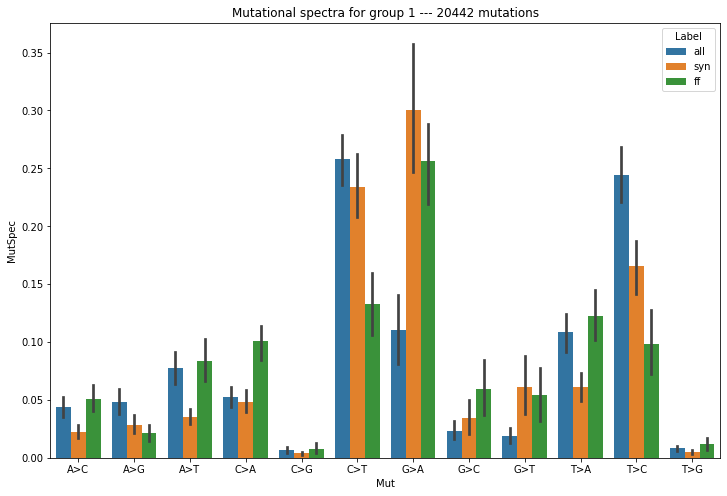

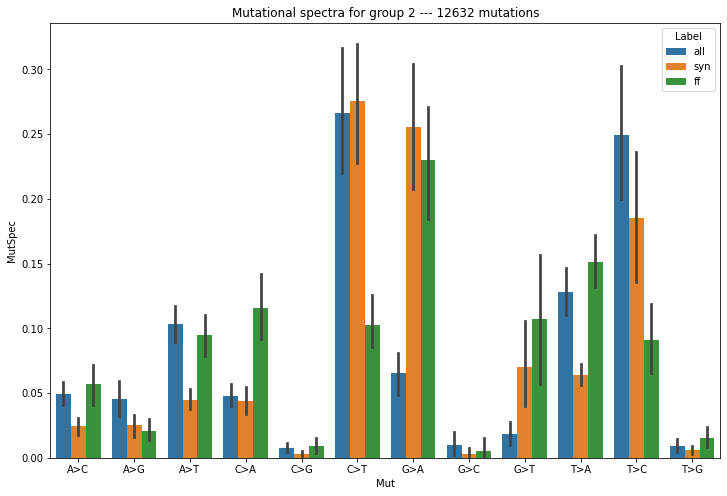

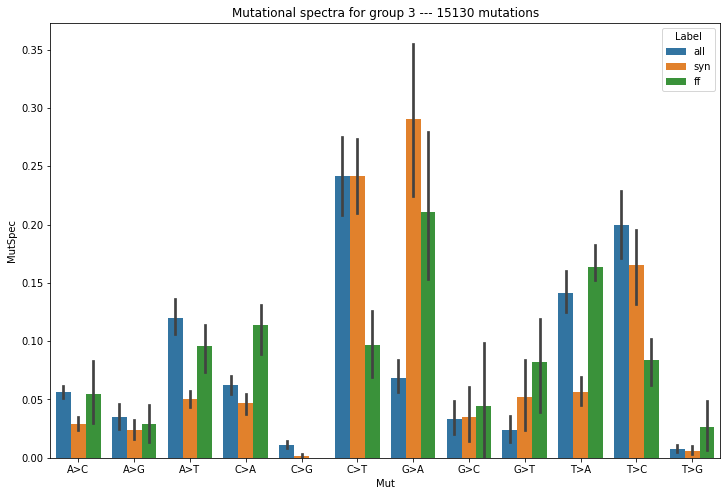

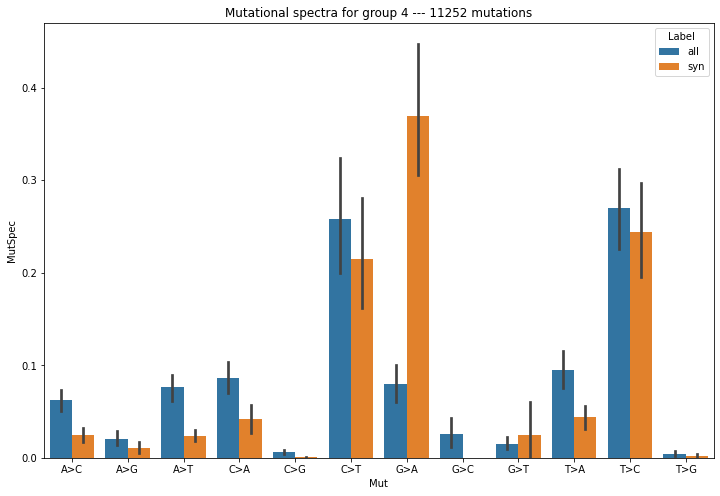

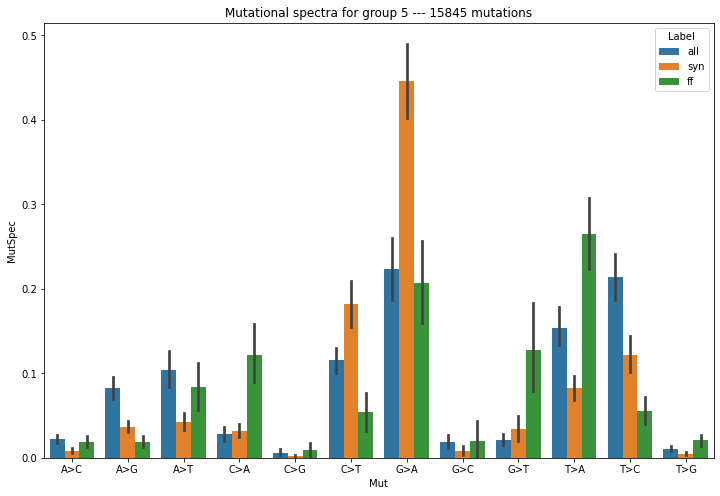

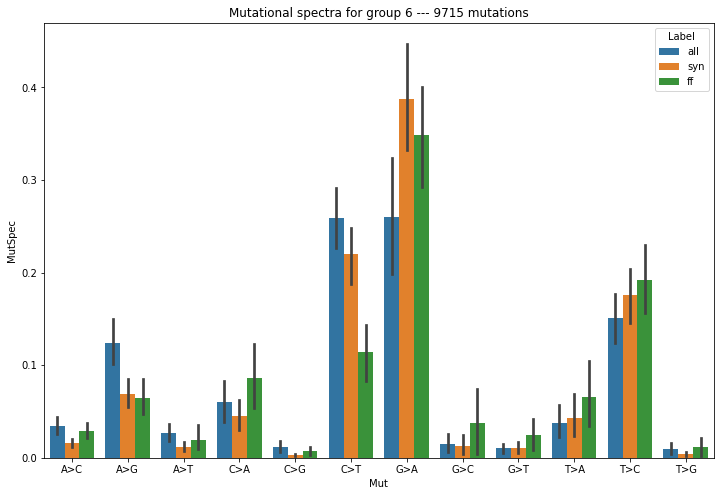

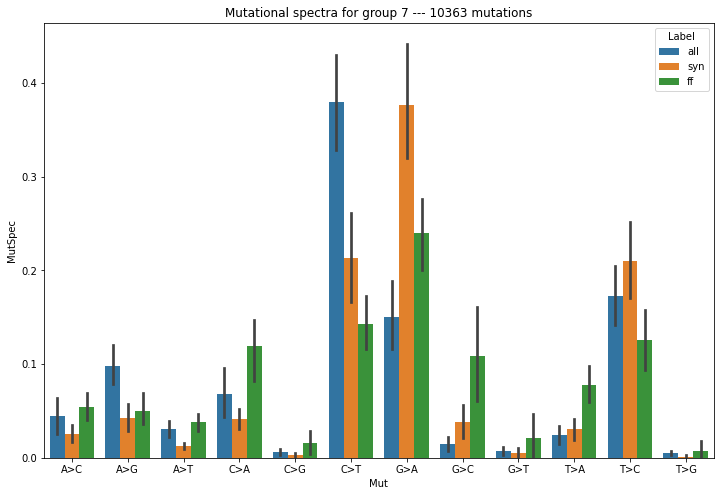

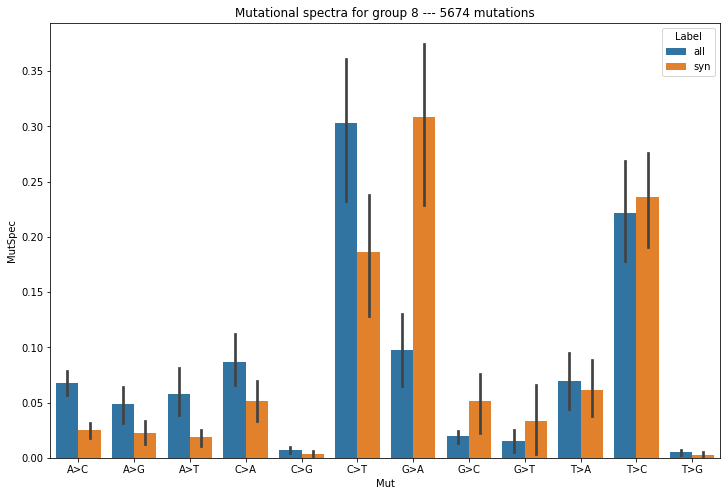

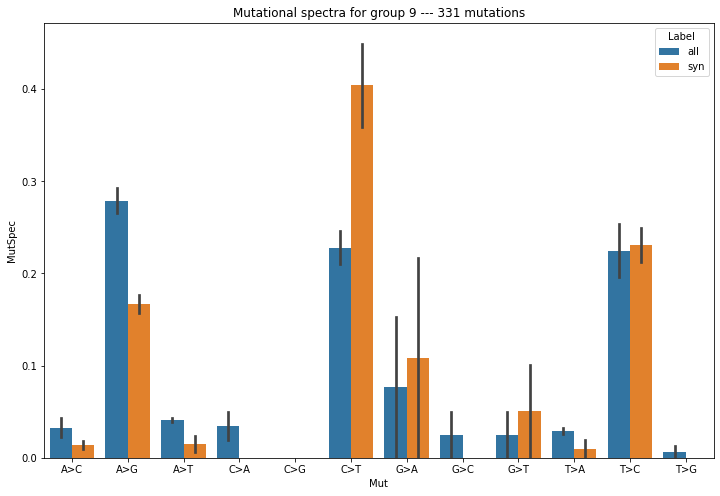

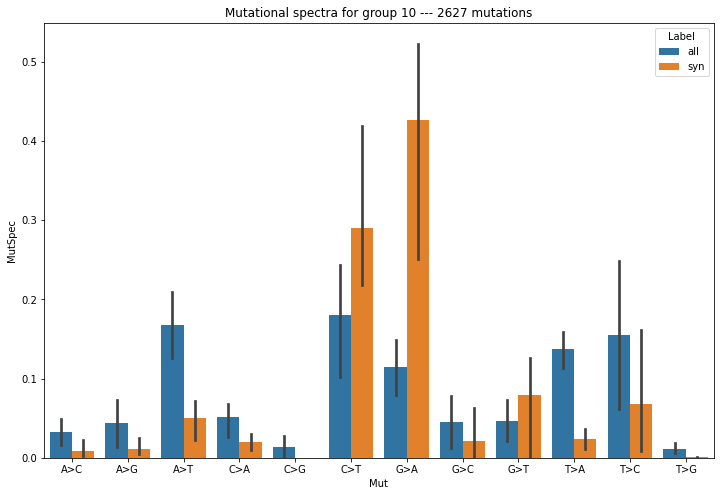

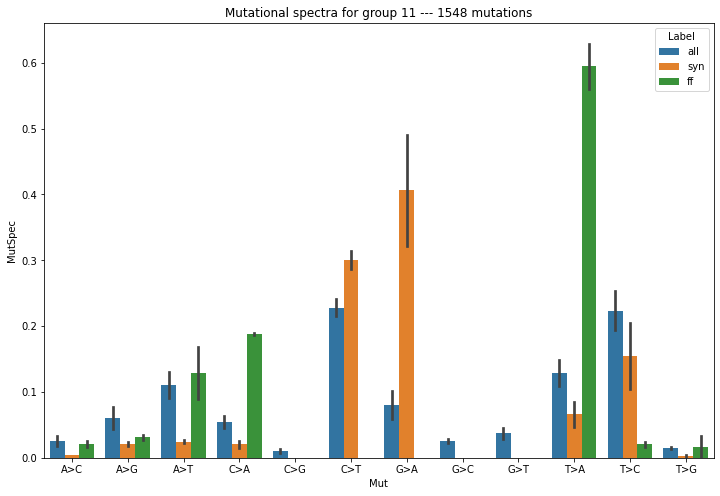

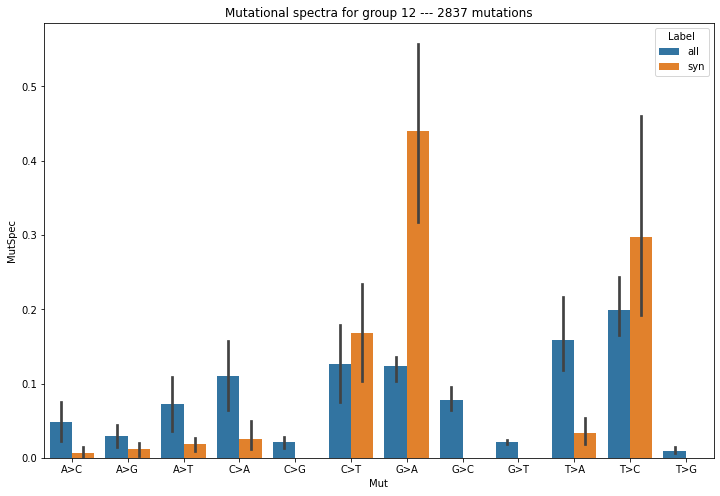

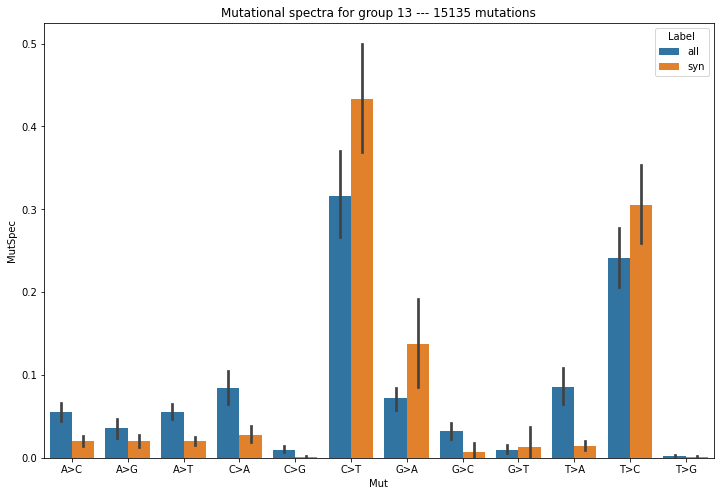

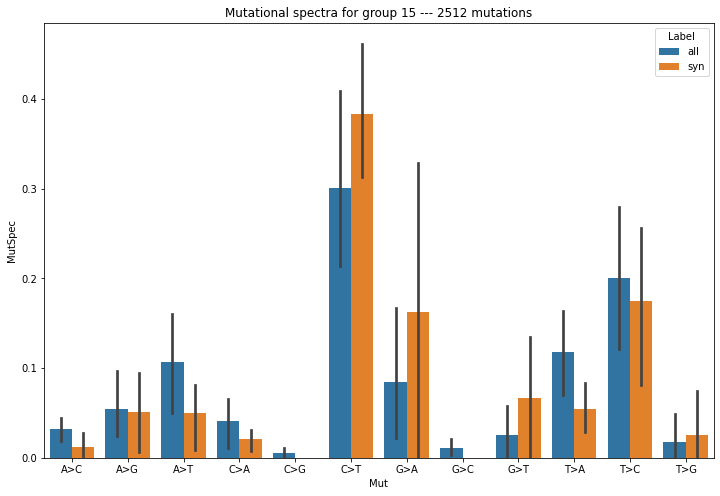

In [153]:
for gr_num in gr_mutspec.Group.unique():
    ms = gr_mutspec[gr_mutspec.Group == gr_num]
    mut_num = ms.ObsFr.sum()
    if mut_num > 50:
        plt.figure(figsize=(12, 8))
        sns.barplot(x="Mut", y="MutSpec", hue="Label", data=ms, order=possible_sbs12)
        plt.title(f"Mutational spectra for group {gr_num} --- {mut_num} mutations")
        plt.show()

## Genes mutspec

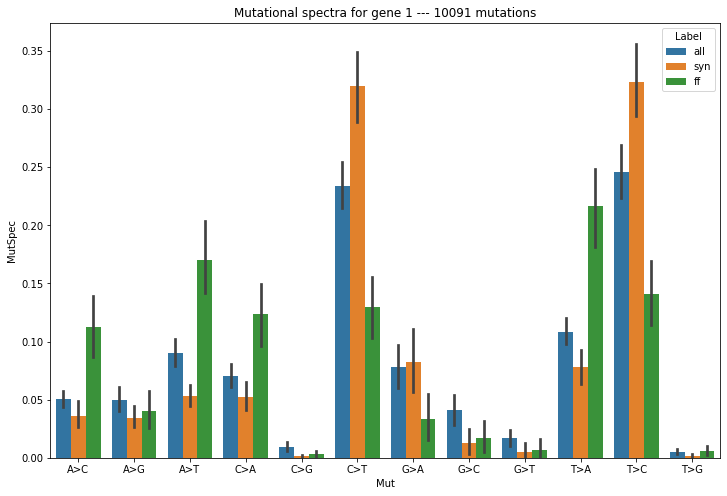

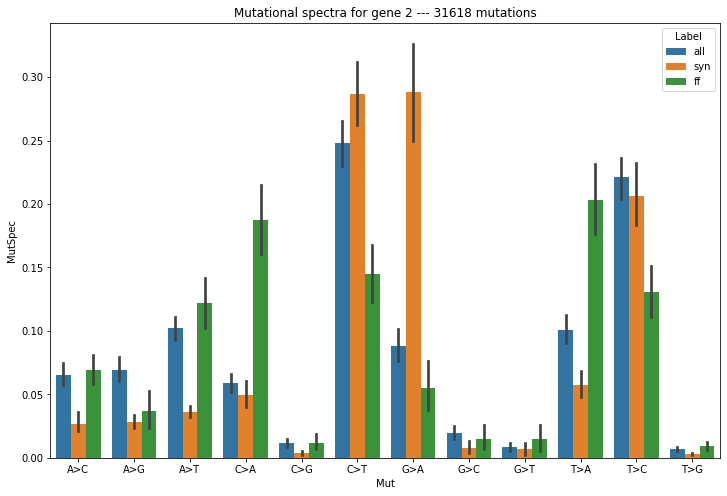

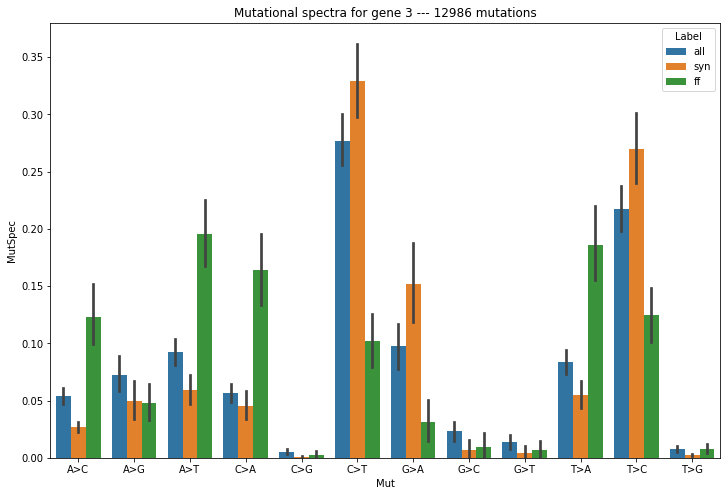

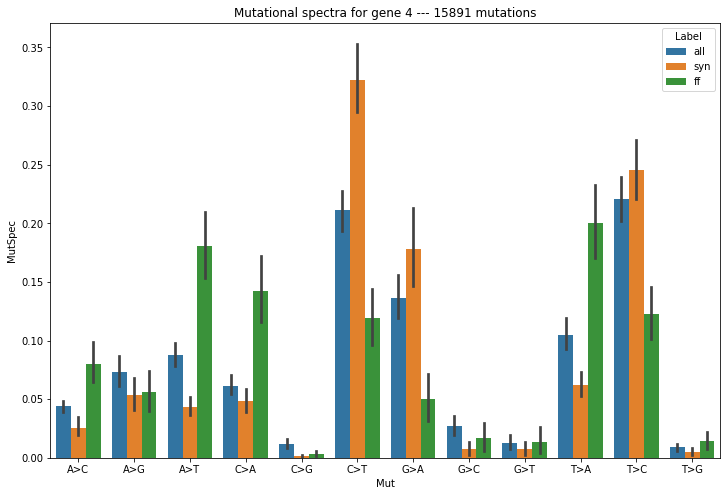

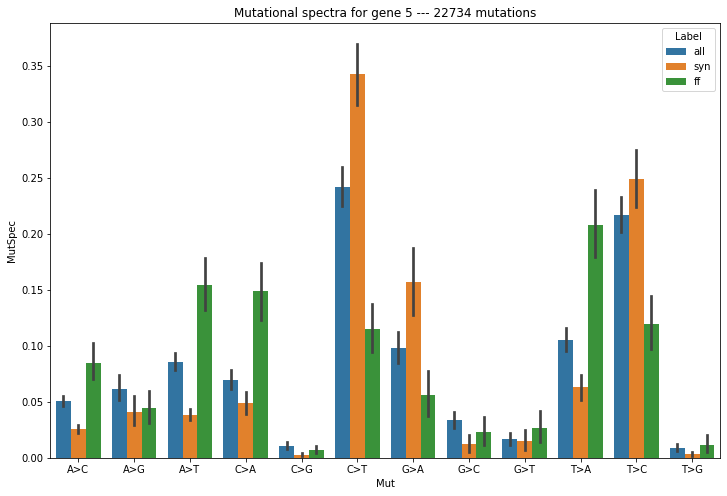

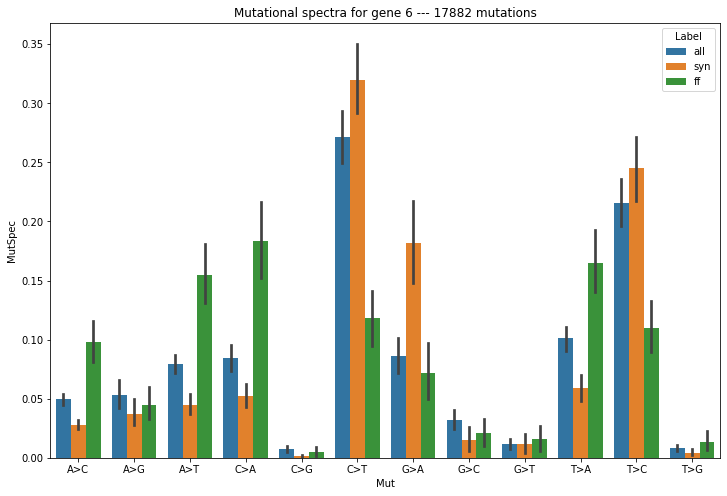

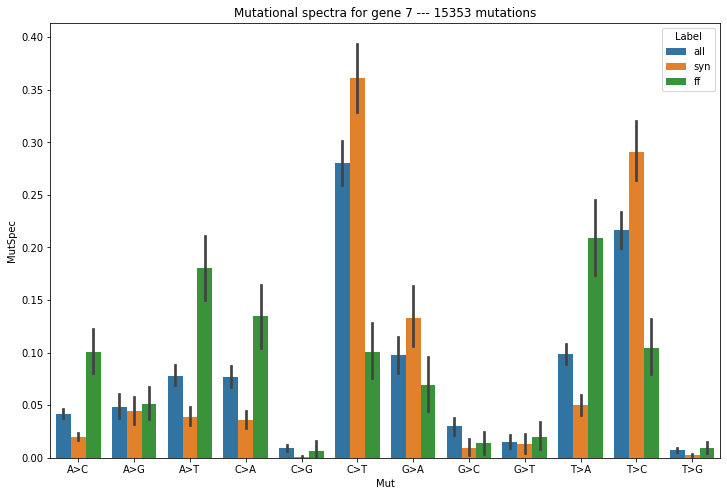

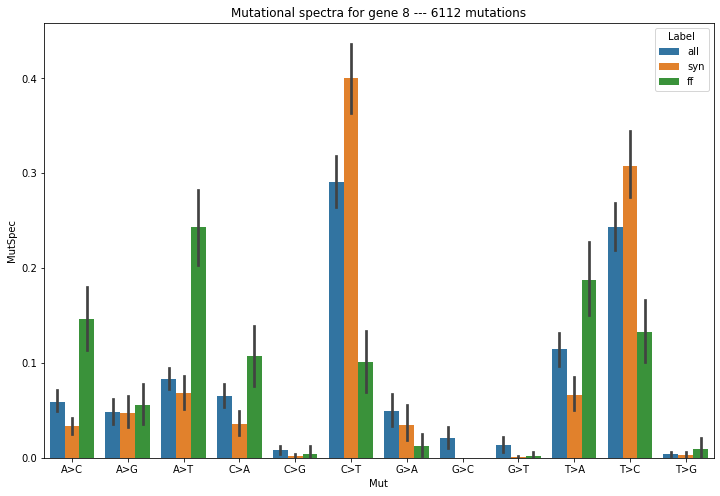

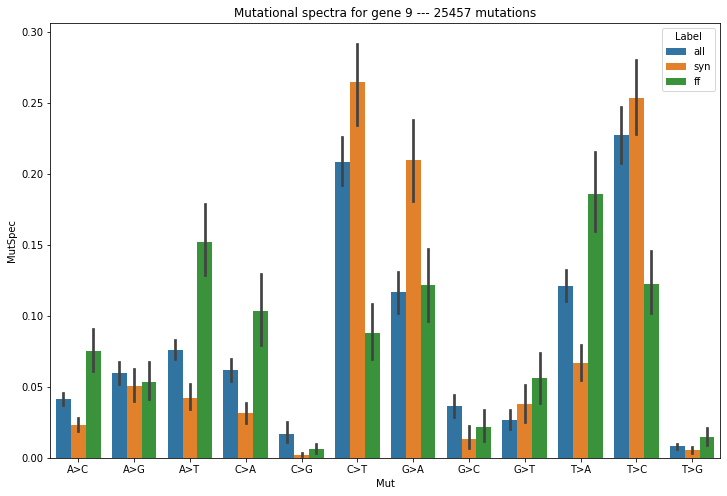

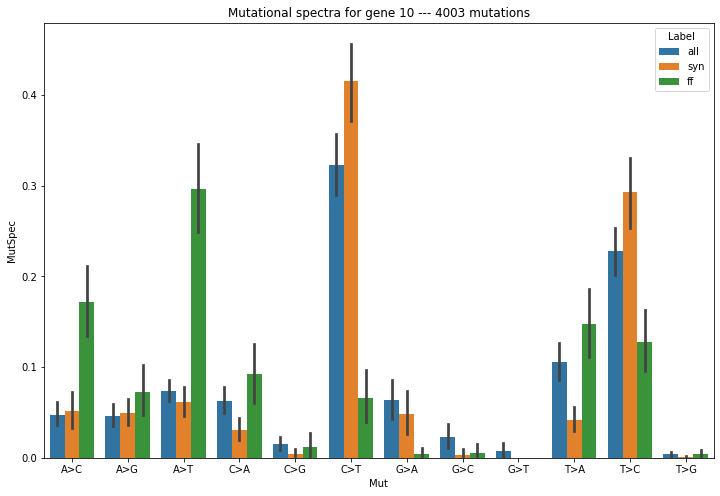

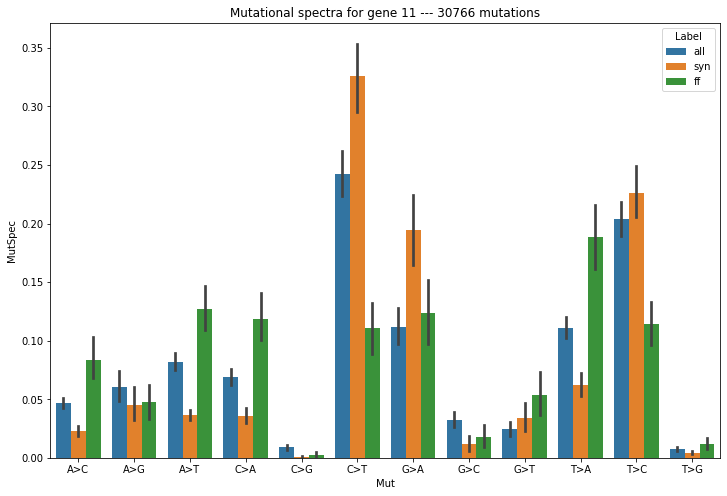

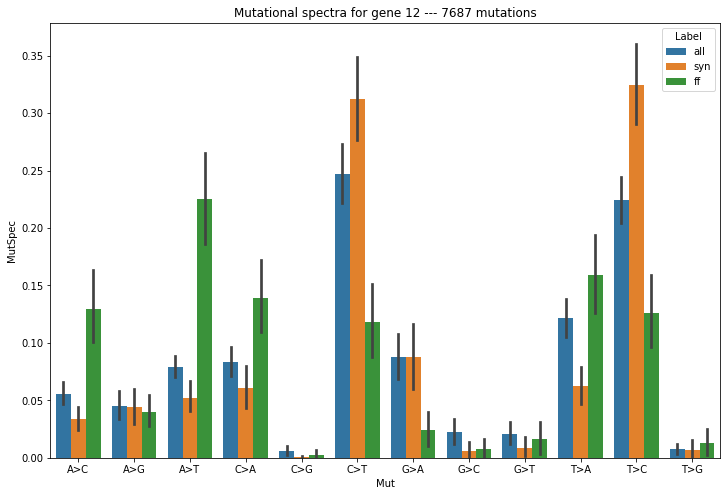

In [176]:
for gene in sorted(edge_mutspec12genes.Gene.unique()):
    ms = edge_mutspec12genes[edge_mutspec12genes.Gene == gene]
    mut_num = ms.ObsFr.sum()
    if mut_num > 50:
        plt.figure(figsize=(12, 8))
        sns.barplot(x="Mut", y="MutSpec", hue="Label", data=ms, order=possible_sbs12)
        plt.title(f"Mutational spectra for gene {gene} --- {mut_num} mutations")
        plt.show()